In [1]:
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import from_json
from pyspark.sql.types import *
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
import time as timer
import argparse
import datetime
import json
from pyspark.sql.functions import col, abs, mean, expr, substring, udf
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor

from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

import random
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
#import lightgbm as lgb

os.environ['PYSPARK_SUBMIT_ARGS'] = '--conf spark.driver.extraJavaOptions=-Dio.netty.tryReflectionSetAccessible=true --conf spark.executor.extraJavaOptions=-Dio.netty.tryReflectionSetAccessible=true pyspark-shell'

schema = StructType(
    [
        StructField("num_date_time", StringType()),
        StructField("건물번호", StringType()),
        StructField("일시", StringType()),
        StructField("기온(C)", StringType()),
        StructField("강수량(mm)", StringType()),
        StructField("풍속(m/s)", StringType()),
        StructField("습도(%)", StringType()),
        StructField("일조(hr)", StringType()),
        StructField("일사(MJ/m2)", StringType()),
        StructField("전력소비량(kWh)", StringType()),
    ]
)

schema2 = StructType(
    [
        StructField("num_date_time", StringType()),
        StructField("건물번호", StringType()),
        StructField("일시", StringType()),
        StructField("기온(C)", StringType()),
        StructField("강수량(mm)", StringType()),
        StructField("풍속(m/s)", StringType()),
        StructField("습도(%)", StringType()),
    ]
)

schema3 = StructType(
    [
        StructField("건물번호", StringType()),
        StructField("건물유형", StringType()),
        StructField("연면적(m2)", StringType()),
        StructField("냉방면적(m2)", StringType()),
        StructField("태양광용량(kW)", StringType()),
        StructField("ESS저장용량(kWh)", StringType()),
        StructField("PCS용량(kW)", StringType()),
    ]
)



print("FILES IN THIS DIRECTORY")
print(os.listdir(os.getcwd()))

FILES IN THIS DIRECTORY
['.bashrc', '.bash_logout', '.profile', '.ipython', '.cache', '.npm', '.bash_history', '.local', '.ipynb_checkpoints', 'config.json', '.jupyter', 'jars', '.conda', '.config', '.wget-hsts', 'work']


## Fixed Random-Seed

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [3]:
#config.json 파일 읽기
with open("config.json", "r") as f:
   config = json.load(f)

jar_urls = ",".join(config["KAFKA_JAR_URLS"])
repartition_num = config["NUM_EXECUTORS"] * config["EXECUTOR_CORES"] * 2



In [4]:
# SparkSession 생성
spark = (
    SparkSession.builder.master("spark://spark-master-service:7077")
    .config("spark.driver.bindAddress", "0.0.0.0")
    .config("spark.driver.host", "10.42.2.18")
    .config("spark.driver.port", "39337")
    .config("spark.cores.max", "48")
    .config("spark.network.timeout", "600s")
    .config("spark.executor.instances", config["NUM_EXECUTORS"])
    .config("spark.executor.cores", config["EXECUTOR_CORES"])
    .config("spark.executor.memory", config["EXECUTOR_MEMORY"])   
    .config("spark.driver.memory", "30g")
    .config("spark.memory.offHeap.enabled", "true")
    .config("spark.memory.offHeap.size","20g")
    
    .config("spark.defaul.parallelism", repartition_num)
    .config("spark.sql.shuffle.partitions", repartition_num)
    .config("spark.driver.extraJavaOptions", "--illegal-access=permit")
    .config("spark.executor.extraJavaOptions", "--illegal-access=permit")
    .config("spark.jars", jar_urls)  # JAR 파일 포함
    .appName("asdf")
    .getOrCreate()
)

sc = spark.sparkContext
sc.setLogLevel("ERROR")

24/05/26 05:16:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
sc

<SparkContext master=spark://spark-master-service:7077 appName=asdf>

In [6]:
print("Current Spark configuration:")
for key, value in sorted(sc._conf.getAll(), key=lambda x: x[0]):
    print(f"{key} = {value}")

Current Spark configuration:
spark.app.id = app-20240526051644-0405
spark.app.initial.jar.urls = spark://10.42.2.18:39337/jars/commons-pool2-2.6.2.jar,spark://10.42.2.18:39337/jars/hadoop-client-api-3.3.1.jar,spark://10.42.2.18:39337/jars/kafka-clients-2.8.1.jar,spark://10.42.2.18:39337/jars/spark-sql-kafka-0-10_2.12-3.2.4.jar,spark://10.42.2.18:39337/jars/hadoop-client-runtime-3.3.1.jar,spark://10.42.2.18:39337/jars/htrace-core4-4.1.0-incubating.jar,spark://10.42.2.18:39337/jars/commons-logging-1.1.3.jar,spark://10.42.2.18:39337/jars/spark-streaming-kafka-0-10_2.12-3.2.4.jar,spark://10.42.2.18:39337/jars/jsr305-3.0.0.jar,spark://10.42.2.18:39337/jars/spark-token-provider-kafka-0-10_2.12-3.2.4.jar
spark.app.name = asdf
spark.app.startTime = 1716700603983
spark.cores.max = 48
spark.defaul.parallelism = 96
spark.driver.bindAddress = 0.0.0.0
spark.driver.extraJavaOptions = --illegal-access=permit
spark.driver.host = 10.42.2.18
spark.driver.memory = 30g
spark.driver.port = 39337
spark.exec

In [7]:
# 그냥 가져오기
building_sdf = (
    spark.read.format("kafka")
    .option("kafka.bootstrap.servers", "my-cluster-kafka-bootstrap.kafka.svc:9092")
    .option("subscribe", "building-jy")
    .option("kafka.group.id", "my_consumer_group")
    .load()
)  # 밀리초 단위 에포치 시간endingTimestamp
building_sdf = building_sdf.selectExpr("CAST(value AS STRING)", "CAST(timestamp AS STRING)")
building_sdf = building_sdf.withColumnRenamed("timestamp", "createTime")
building_sdf = building_sdf.withColumn("value", from_json(building_sdf["value"], schema3))


for field in schema3.fields:
    building_sdf = building_sdf.withColumn(field.name, building_sdf["value." + field.name])
building_sdf = building_sdf.drop("value")
# 이거쓰면 df가 repartition_num 수만큼 쪼개져서 병렬처리가능한 상태가 됨.
building_sdf = building_sdf.repartition(repartition_num)


building_sdf.printSchema()

root
 |-- createTime: string (nullable = true)
 |-- 건물번호: string (nullable = true)
 |-- 건물유형: string (nullable = true)
 |-- 연면적(m2): string (nullable = true)
 |-- 냉방면적(m2): string (nullable = true)
 |-- 태양광용량(kW): string (nullable = true)
 |-- ESS저장용량(kWh): string (nullable = true)
 |-- PCS용량(kW): string (nullable = true)



In [8]:
building_sdf = building_sdf.select(
    building_sdf["createTime"],
    building_sdf["건물번호"],
    building_sdf["건물유형"],
    building_sdf["연면적(m2)"],
    building_sdf["냉방면적(m2)"],
    building_sdf["태양광용량(kW)"],
    building_sdf["ESS저장용량(kWh)"],
    building_sdf["PCS용량(kW)"]
) \
.withColumn("createTime", building_sdf["createTime"].cast(StringType())) \
.withColumn("건물번호", building_sdf["건물번호"].cast(IntegerType())) \
.withColumn("건물유형", building_sdf["건물유형"].cast(StringType())) \
.withColumn("연면적(m2)", building_sdf["연면적(m2)"].cast(DoubleType())) \
.withColumn("냉방면적(m2)", building_sdf["냉방면적(m2)"].cast(DoubleType())) \
.withColumn("태양광용량(kW)", building_sdf["태양광용량(kW)"].cast(DoubleType())) \
.withColumn("ESS저장용량(kWh)", building_sdf["ESS저장용량(kWh)"].cast(IntegerType())) \
.withColumn("PCS용량(kW)", building_sdf["PCS용량(kW)"].cast(IntegerType()))


In [9]:
building_sdf.show()

+--------------------+--------+--------------+-----------+------------+--------------+----------------+-----------+
|          createTime|건물번호|      건물유형| 연면적(m2)|냉방면적(m2)|태양광용량(kW)|ESS저장용량(kWh)|PCS용량(kW)|
+--------------------+--------+--------------+-----------+------------+--------------+----------------+-----------+
|2024-05-21 01:23:...|      20|          공공|1.2872877E7| 1.0941945E7|          null|            null|       null|
|2024-05-21 01:24:...|      34|    데이터센터|    10665.0|      9402.0|          null|            null|       null|
|2024-05-21 01:24:...|       8|      건물기타|   75344.54|     24117.0|          null|            null|       null|
|2024-05-21 01:24:...|      33|    데이터센터|    28059.0|     20397.0|          null|            null|       null|
|2024-05-21 01:23:...|      31|        대학교|   201781.0|    119836.0|         83.72|            null|       null|
|2024-05-21 01:24:...|      44|백화점및아울렛|   78116.83|    76458.32|          null|            null|       null|
|2024-05

In [10]:
# 그냥 가져오기
test_sdf = (
    spark.read.format("kafka")
    .option("kafka.bootstrap.servers", "my-cluster-kafka-bootstrap.kafka.svc:9092")
    .option("subscribe", "test2-jy")
    .option("kafka.group.id", "my_consumer_group")
    .load()
)  # 밀리초 단위 에포치 시간endingTimestamp
test_sdf = test_sdf.selectExpr("CAST(value AS STRING)", "CAST(timestamp AS STRING)")
test_sdf = test_sdf.withColumnRenamed("timestamp", "createTime")
test_sdf = test_sdf.withColumn("value", from_json(test_sdf["value"], schema2))


for field in schema2.fields:
    test_sdf = test_sdf.withColumn(field.name, test_sdf["value." + field.name])
test_sdf = test_sdf.drop("value")
# 이거쓰면 df가 repartition_num 수만큼 쪼개져서 병렬처리가능한 상태가 됨.
test_sdf = test_sdf.repartition(repartition_num)


test_sdf.printSchema()

root
 |-- createTime: string (nullable = true)
 |-- num_date_time: string (nullable = true)
 |-- 건물번호: string (nullable = true)
 |-- 일시: string (nullable = true)
 |-- 기온(C): string (nullable = true)
 |-- 강수량(mm): string (nullable = true)
 |-- 풍속(m/s): string (nullable = true)
 |-- 습도(%): string (nullable = true)



In [11]:
test_sdf = test_sdf.select(
    test_sdf["createTime"],
    test_sdf["num_date_time"],
    test_sdf["건물번호"],
    test_sdf["일시"],
    test_sdf["기온(C)"],
    test_sdf["강수량(mm)"],
    test_sdf["풍속(m/s)"],
    test_sdf["습도(%)"]
) \
.withColumn("createTime", test_sdf["createTime"].cast(StringType())) \
.withColumn("num_date_time", test_sdf["num_date_time"].cast(StringType())) \
.withColumn("건물번호", test_sdf["건물번호"].cast(IntegerType())) \
.withColumn("일시", test_sdf["일시"].cast(StringType())) \
.withColumn("기온(C)", test_sdf["기온(C)"].cast(DoubleType())) \
.withColumn("강수량(mm)", test_sdf["강수량(mm)"].cast(DoubleType())) \
.withColumn("풍속(m/s)", test_sdf["풍속(m/s)"].cast(DoubleType())) \
.withColumn("습도(%)", test_sdf["습도(%)"].cast(IntegerType()))

In [12]:
test_sdf.show()

+--------------------+--------------+--------+-----------+-------+----------+---------+-------+
|          createTime| num_date_time|건물번호|       일시|기온(C)|강수량(mm)|풍속(m/s)|습도(%)|
+--------------------+--------------+--------+-----------+-------+----------+---------+-------+
|2024-05-21 01:23:...|74_20220827 08|      74|20220827 08|   18.3|       0.0|      2.1|     77|
|2024-05-21 01:23:...|57_20220827 03|      57|20220827 03|   20.7|       2.0|      2.7|     91|
|2024-05-21 01:23:...|24_20220827 09|      24|20220827 09|   19.5|       0.0|      2.4|     63|
|2024-05-21 01:23:...|94_20220829 04|      94|20220829 04|   21.8|       0.0|      1.3|     66|
|2024-05-21 01:23:...| 5_20220829 15|       5|20220829 15|   22.2|       0.0|      1.8|     73|
|2024-05-21 01:23:...|35_20220831 04|      35|20220831 04|   19.8|       0.0|      1.2|     94|
|2024-05-21 01:23:...|67_20220827 04|      67|20220827 04|   22.6|       0.0|      3.2|     79|
|2024-05-21 01:23:...|63_20220830 20|      63|20220830 

In [13]:
# 그냥 가져오기
train_sdf = (
    spark.read.format("kafka")
    .option("kafka.bootstrap.servers", "my-cluster-kafka-bootstrap.kafka.svc:9092")
    .option("subscribe", "test-jy")
    .option("kafka.group.id", "my_consumer_group")
    .load()
)  # 밀리초 단위 에포치 시간endingTimestamp

train_sdf = train_sdf.selectExpr("CAST(value AS STRING)", "CAST(timestamp AS STRING)")
train_sdf = train_sdf.withColumnRenamed("timestamp", "createTime")
train_sdf = train_sdf.withColumn("value", from_json(train_sdf["value"], schema))


for field in schema.fields:
    train_sdf = train_sdf.withColumn(field.name, train_sdf["value." + field.name])
train_sdf = train_sdf.drop("value")
# 이거쓰면 df가 repartition_num 수만큼 쪼개져서 병렬처리가능한 상태가 됨.


train_sdf = train_sdf.repartition(repartition_num)

train_sdf.printSchema()


root
 |-- createTime: string (nullable = true)
 |-- num_date_time: string (nullable = true)
 |-- 건물번호: string (nullable = true)
 |-- 일시: string (nullable = true)
 |-- 기온(C): string (nullable = true)
 |-- 강수량(mm): string (nullable = true)
 |-- 풍속(m/s): string (nullable = true)
 |-- 습도(%): string (nullable = true)
 |-- 일조(hr): string (nullable = true)
 |-- 일사(MJ/m2): string (nullable = true)
 |-- 전력소비량(kWh): string (nullable = true)



In [14]:
train_sdf = train_sdf.select(
    train_sdf["createTime"],
    train_sdf["num_date_time"],
    train_sdf["건물번호"],
    train_sdf["일시"],
    train_sdf["기온(C)"],
    train_sdf["강수량(mm)"],
    train_sdf["풍속(m/s)"],
    train_sdf["습도(%)"],
    train_sdf["일조(hr)"],
    train_sdf["일사(MJ/m2)"],
    train_sdf["전력소비량(kWh)"],
) \
.withColumn("createTime", train_sdf["createTime"].cast(StringType())) \
.withColumn("num_date_time", train_sdf["num_date_time"].cast(StringType())) \
.withColumn("건물번호", train_sdf["건물번호"].cast(IntegerType())) \
.withColumn("일시", train_sdf["일시"].cast(StringType())) \
.withColumn("기온(C)", train_sdf["기온(C)"].cast(DoubleType())) \
.withColumn("강수량(mm)", train_sdf["강수량(mm)"].cast(DoubleType())) \
.withColumn("풍속(m/s)", train_sdf["풍속(m/s)"].cast(DoubleType())) \
.withColumn("습도(%)", train_sdf["습도(%)"].cast(IntegerType())) \
.withColumn("일조(hr)", train_sdf["일조(hr)"].cast(DoubleType())) \
.withColumn("일사(MJ/m2)", train_sdf["일사(MJ/m2)"].cast(DoubleType())) \
.withColumn("전력소비량(kWh)", train_sdf["전력소비량(kWh)"].cast(DoubleType()))

In [15]:
train_sdf.show()

+--------------------+--------------+--------+-----------+-------+----------+---------+-------+--------+-----------+---------------+
|          createTime| num_date_time|건물번호|       일시|기온(C)|강수량(mm)|풍속(m/s)|습도(%)|일조(hr)|일사(MJ/m2)|전력소비량(kWh)|
+--------------------+--------------+--------+-----------+-------+----------+---------+-------+--------+-----------+---------------+
|2024-05-21 01:17:...|15_20220606 04|      15|20220606 04|   16.9|       0.2|      0.6|    100|    null|       null|        1287.18|
|2024-05-21 01:18:...|85_20220605 13|      85|20220605 13|   24.8|      null|      3.7|     50|     0.0|       0.53|        2337.84|
|2024-05-21 01:17:...|37_20220617 00|      37|20220617 00|   18.7|      null|      1.3|     80|    null|       null|         1035.6|
|2024-05-21 01:18:...|81_20220808 19|      81|20220808 19|   25.6|      12.5|      2.5|     96|     0.0|       0.04|        2521.08|
|2024-05-21 01:17:...|22_20220607 14|      22|20220607 14|   22.5|      null|      2.5|     5

In [37]:
def train_test_split(df, th):
    df = df.na.drop(subset=['일시'])
    train = df.filter(col('일시').substr(1, 8).cast(IntegerType()) < th)
    test = df.filter(col('일시').substr(1, 8).cast(IntegerType()) >= th)
    return train, test

def preprocess_x(df):
    to_remove_columns = ['num_date_time', '일시', '일조(hr)', '일사(MJ/m2)']
    df = df.fillna(0)   
    
    # 시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나눕니다
    df = df.withColumn('month', substring('일시', 5, 2).cast(IntegerType()))
    df = df.withColumn('day', substring('일시', 7, 2).cast(IntegerType()))
    df = df.withColumn('time', substring('일시', 10, 2).cast(IntegerType()))
    
    
    
    df = df.join(building_sdf.select('건물번호', '건물유형', '연면적(m2)'), on='건물번호', how='left')
    df = df.dropDuplicates()
    
    
    # '건물유형'을 카테고리형 코드로 변환
    building_type_indexer = StringIndexer(inputCol='건물유형', outputCol='건물유형_index')
    df = building_type_indexer.fit(df).transform(df)
    df = df.drop('건물유형').withColumnRenamed('건물유형_index', '건물유형')
    
    # 불필요한 컬럼 삭제
    for c in to_remove_columns:
        if c in df.columns:
            df = df.drop(c)
            
    df.show(20, truncate=False)
    return df


date_th = 20220820

In [39]:

train_df, valid_df = train_test_split(train_sdf, date_th)


#print("train_df DataFrame show:", train_df.show())
#print("valid_df DataFrame show:", valid_df.show())

# 데이터 분할 후 각 데이터프레임의 크기를 확인합니다.
print("train_df shape(split 후):", train_df.count(), len(train_df.columns))
print("valid_df shape(split 후):", valid_df.count(), len(valid_df.columns))



train_df shape(split 후): 192000 11


valid_df shape(split 후): 12000 11


In [101]:

train_1 = preprocess_x(train_df)
#train_y = train_df.select("전력소비량(kWh)")

# 전처리 후 데이터프레임의 크기를 확인합니다.
print("train_1 shape:", train_1.count(), len(train_1.columns))
#print("Train Y shape:", train_y.count(), len(train_y.columns))

valid_1 = preprocess_x(valid_df)
#valid_y = valid_df.select("전력소비량(kWh)")

print("valid_1 shape:", valid_1.count(), len(valid_1.columns))
#print("Validation Y shape:", valid_y.count(), len(valid_y.columns))


+--------+-----------------------+-------+----------+---------+-------+---------------+-----+---+----+----------+--------+
|건물번호|createTime             |기온(C)|강수량(mm)|풍속(m/s)|습도(%)|전력소비량(kWh)|month|day|time|연면적(m2)|건물유형|
+--------+-----------------------+-------+----------+---------+-------+---------------+-----+---+----+----------+--------+
|23      |2024-05-21 01:17:22.13 |22.1   |0.0       |1.5      |88     |1054.8         |8    |19 |4   |32236.11  |1.0     |
|42      |2024-05-21 01:17:44.682|26.1   |0.0       |4.3      |74     |2929.32        |6    |25 |16  |97915.1   |3.0     |
|79      |2024-05-21 01:18:30.428|22.4   |0.0       |1.4      |96     |3010.56        |8    |18 |7   |212995.84 |8.0     |
|39      |2024-05-21 01:17:41.702|27.9   |0.0       |1.0      |80     |711.36         |8    |5  |23  |126835.0  |3.0     |
|64      |2024-05-21 01:18:11.493|24.6   |0.0       |1.5      |87     |1091.7         |7    |18 |8   |240551.0  |6.0     |
|24      |2024-05-21 01:17:22.423|19.8   

train_1 shape: 192000 12
+--------+-----------------------+-------+----------+---------+-------+---------------+-----+---+----+----------+--------+
|건물번호|createTime             |기온(C)|강수량(mm)|풍속(m/s)|습도(%)|전력소비량(kWh)|month|day|time|연면적(m2)|건물유형|
+--------+-----------------------+-------+----------+---------+-------+---------------+-----+---+----+----------+--------+
|59      |2024-05-21 01:18:06.081|24.8   |0.0       |1.3      |87     |3519.72        |8    |23 |10  |105500.72 |5.0     |
|97      |2024-05-21 01:18:51.815|27.9   |0.0       |2.9      |80     |1562.94        |8    |21 |19  |55144.67  |10.0    |
|86      |2024-05-21 01:18:38.789|26.0   |0.0       |1.6      |98     |649.08         |8    |20 |6   |54866.51  |9.0     |
|38      |2024-05-21 01:17:40.795|25.8   |0.0       |1.4      |83     |3213.0         |8    |23 |11  |58763.89  |3.0     |
|49      |2024-05-21 01:17:53.502|24.6   |0.0       |0.0      |99     |2731.68        |8    |21 |2   |112953.61 |4.0     |
|49      |2024-0

valid_1 shape: 12000 12


In [ ]:
#spark.stop()

In [41]:
train_1.show()

+--------+--------------------+-------+----------+---------+-------+---------------+-----+---+----+----------+--------+
|건물번호|          createTime|기온(C)|강수량(mm)|풍속(m/s)|습도(%)|전력소비량(kWh)|month|day|time|연면적(m2)|건물유형|
+--------+--------------------+-------+----------+---------+-------+---------------+-----+---+----+----------+--------+
|       1|2024-05-21 01:16:...|   19.9|       0.0|      1.5|     89|        2010.72|    6| 15|  19|  110634.0|     0.0|
|      53|2024-05-21 01:17:...|   23.5|       0.0|      0.9|     78|         900.96|    6| 23|   3|  149246.0|     5.0|
|       5|2024-05-21 01:17:...|   23.2|       0.0|      1.0|     93|         1688.4|    7| 17|   1|  205884.0|     0.0|
|      35|2024-05-21 01:17:...|   27.9|       0.0|      0.8|     78|         2190.0|    7|  5|   9|    9736.0|    11.0|
|      13|2024-05-21 01:17:...|   23.3|       0.0|      5.3|    100|         2186.4|    6| 23|  10|    5578.4|     0.0|
|      99|2024-05-21 01:18:...|   22.5|       0.0|      2.3|     

In [102]:
valid_1.show()

+--------+--------------------+-------+----------+---------+-------+---------------+-----+---+----+----------+--------+
|건물번호|          createTime|기온(C)|강수량(mm)|풍속(m/s)|습도(%)|전력소비량(kWh)|month|day|time|연면적(m2)|건물유형|
+--------+--------------------+-------+----------+---------+-------+---------------+-----+---+----+----------+--------+
|      49|2024-05-21 01:17:...|   26.3|       0.0|      1.0|     99|        3003.48|    8| 20|  20| 112953.61|     4.0|
|      53|2024-05-21 01:17:...|   27.7|       0.0|      2.2|     61|        3296.16|    8| 24|  12|  149246.0|     5.0|
|      56|2024-05-21 01:18:...|   22.5|       0.0|      2.7|     84|        4158.36|    8| 24|   6|  42666.54|     5.0|
|      34|2024-05-21 01:17:...|   26.3|       0.0|      3.2|     95|        3475.44|    8| 20|   2|   10665.0|    11.0|
|      95|2024-05-21 01:18:...|   19.9|       0.0|      0.1|     92|         928.08|    8| 24|  22| 196992.54|    10.0|
|      88|2024-05-21 01:18:...|   24.3|       0.0|      1.9|     

### 0. Functions For validation

In [42]:
def SMAPE(y, pred):
    smape = abs((y - pred))/((abs(y) + abs(pred)) / 2) * 100
    smape = np.mean(smape)
    return smape

def mae(y, pred):
    return np.mean(abs(y-pred))

In [43]:
def validate(valid_x, valid_y, model):
    pred = model.predict(valid_x)
    smape_score, mae_score = SMAPE(valid_y, pred), mae(valid_y, pred)
    return smape_score, mae_score

## 2. Multi Models by building num
- 건물번호(1~100)별 모델을 각각 만들어 성능을 측정하였습니다.
- 건물별로 building_info값은 같기 때문에 해당 데이터는 제외했습니다(건물번호, 건물유형, 연면적, 냉방면적).

In [118]:
from pyspark.ml.evaluation import RegressionEvaluator

def validate_multi(valid_1, models):
    """
    Args:
        models: dict, {1: model1, 2: model2, ..., 100: model100}
    """
    
    mse_eval = RegressionEvaluator(labelCol='전력소비량(kWh)', predictionCol='prediction', metricName='mse')
    rmse_eval = RegressionEvaluator(labelCol='전력소비량(kWh)', predictionCol='prediction', metricName='rmse')
    r2_eval = RegressionEvaluator(labelCol='전력소비량(kWh)', predictionCol='prediction', metricName='r2')

    predictions=[0 for _ in range(101)]
    for i in tqdm(range(1, 101)):
        aB = valid_1.filter(col('건물번호') == i)
        
        aB = aB.drop('건물번호', '건물유형', '연면적(m2)', '냉방면적(m2)', 'createTime')
        
        feature_cols = [c for c in aB.columns if c != '전력소비량(kWh)']
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
        aB = assembler.transform(aB).select("features", "전력소비량(kWh)")
        
        
        predictions[i] = models[i].transform(aB)
        print('mse:', mse_eval.evaluate(predictions[i]), 'rmse:', rmse_eval.evaluate(predictions[i]), 'r2:', r2_eval.evaluate(predictions[i]))
        
    return predictions

In [114]:
def train_multiple_models(train_1, n_estimators=100):
    models = {}
    
    for i in tqdm(range(1, 101)):
        aBuilding = train_1.filter(col('건물번호') == i)
        
        aBuilding = aBuilding.drop('건물번호', '건물유형', '연면적(m2)', '냉방면적(m2)', 'createTime')
        
        #feature 벡터화
        feature_cols = [c for c in aBuilding.columns if c != '전력소비량(kWh)']
        assembler = VectorAssembler(inputCols = feature_cols, outputCol = "features")
        aBuilding = assembler.transform(aBuilding).select("features", "전력소비량(kWh)")
        
        rf = RandomForestRegressor(featuresCol='features', labelCol='전력소비량(kWh)', numTrees=n_estimators)
        aBuilding = aBuilding.repartition(200)
        model = rf.fit(aBuilding)
        
        models[i] = model
        
        
    return models

In [115]:
models1 = train_multiple_models(train_1)

100%|██████████| 100/100 [22:04<00:00, 13.24s/it]                               


In [121]:
predictions = []

In [122]:
predictions = validate_multi(valid_1, models1)


  1%|          | 1/100 [00:21<35:24, 21.46s/it]

mse: 160510.84580451043 rmse: 400.6380483734794 r2: 0.8391046776519901


  2%|▏         | 2/100 [00:43<35:31, 21.75s/it]                                 

mse: 140894.27846032116 rmse: 375.35886623379656 r2: 0.5225004317412898


  3%|▎         | 3/100 [01:04<34:49, 21.54s/it]

mse: 118319.84386836115 rmse: 343.9765164489593 r2: 0.6173743839264818


  4%|▍         | 4/100 [01:26<34:40, 21.67s/it]                                 

mse: 8488.585475882674 rmse: 92.13351982792511 r2: 0.9154520271911657


  5%|▌         | 5/100 [01:48<34:17, 21.66s/it]                                 

mse: 3011156.4339914173 rmse: 1735.2684040203746 r2: 0.2394179504930355


  6%|▌         | 6/100 [02:10<34:05, 21.76s/it]                                 

mse: 27780.528199924967 rmse: 166.6749177288682 r2: 0.9550488649290526


  7%|▋         | 7/100 [02:31<33:39, 21.71s/it]                                 

mse: 35044.939899625606 rmse: 187.20293774304292 r2: 0.5786171364979816


  8%|▊         | 8/100 [02:53<33:23, 21.78s/it]                                 

mse: 28269.106117491283 rmse: 168.1341908045216 r2: 0.14866687385875244


  9%|▉         | 9/100 [03:15<32:59, 21.75s/it]                                 

mse: 50595.092139868175 rmse: 224.93352826972716 r2: 0.9294630127908793


 10%|█         | 10/100 [03:36<32:31, 21.68s/it]                                

mse: 422045.4464452607 rmse: 649.6502493228652 r2: -1.4307086357028251


 11%|█         | 11/100 [03:58<32:07, 21.66s/it]                                

mse: 14071.54055627488 rmse: 118.62352446405762 r2: 0.8219430420104334


 12%|█▏        | 12/100 [04:20<31:51, 21.72s/it]                                

mse: 33286.48753192507 rmse: 182.44584821783442 r2: 0.5533033989807443


 13%|█▎        | 13/100 [04:42<31:33, 21.76s/it]                                

mse: 40807.43129211989 rmse: 202.00849311877926 r2: 0.3644278794855872


 14%|█▍        | 14/100 [05:03<31:08, 21.72s/it]

mse: 219511.60896995472 rmse: 468.52066013139125 r2: -0.17205815704536542


 15%|█▌        | 15/100 [05:25<30:41, 21.67s/it]                                

mse: 35134.33033622541 rmse: 187.44153844925998 r2: 0.2969083430499081


 16%|█▌        | 16/100 [05:47<30:26, 21.74s/it]

mse: 94561.92774221247 rmse: 307.5092319625745 r2: 0.9472917123603279


 17%|█▋        | 17/100 [06:09<30:06, 21.77s/it]

mse: 142247.1679118585 rmse: 377.15668880699764 r2: 0.19201915673111425


 18%|█▊        | 18/100 [06:30<29:40, 21.71s/it]

mse: 149137.58949199234 rmse: 386.1833625261354 r2: 0.4690039229638674


 19%|█▉        | 19/100 [06:52<29:23, 21.77s/it]                                

mse: 237747.9782987014 rmse: 487.5940712300564 r2: 0.4874796983737041


 20%|██        | 20/100 [07:14<29:05, 21.82s/it]

mse: 777251.5303888913 rmse: 881.6186989786976 r2: 0.2709308528295944


 21%|██        | 21/100 [07:36<28:47, 21.86s/it]                                

mse: 504447.6895243907 rmse: 710.2448095722985 r2: 0.20591835386863566


 22%|██▏       | 22/100 [07:58<28:23, 21.84s/it]                                

mse: 45075.942725048386 rmse: 212.31095761888594 r2: 0.48887378491260136


 23%|██▎       | 23/100 [08:19<27:47, 21.66s/it]                                

mse: 48168.919050700715 rmse: 219.47418766383606 r2: 0.3600986832244414


 24%|██▍       | 24/100 [08:41<27:25, 21.65s/it]                                

mse: 2873215.215476663 rmse: 1695.056109831372 r2: 0.6239248843680619


 25%|██▌       | 25/100 [09:02<27:02, 21.63s/it]                                

mse: 2335363.3489739853 rmse: 1528.189565784947 r2: 0.5657419482780519


 26%|██▌       | 26/100 [09:24<26:32, 21.52s/it]                                

mse: 485207.73582470237 rmse: 696.5685435222456 r2: 0.42998278875059937


 27%|██▋       | 27/100 [09:46<26:21, 21.66s/it]                                

mse: 5055269.892423617 rmse: 2248.3927353608883 r2: 0.31330680354450446


 28%|██▊       | 28/100 [10:07<26:05, 21.75s/it]                                

mse: 176392.01821655539 rmse: 419.99049776936073 r2: 0.28189025983135796


 29%|██▉       | 29/100 [10:29<25:34, 21.61s/it]

mse: 104243.24894337347 rmse: 322.867231139014 r2: 0.33213602868456293


 30%|███       | 30/100 [10:50<25:13, 21.62s/it]                                

mse: 67088.6493186363 rmse: 259.0147666034435 r2: 0.0813544563990225


 31%|███       | 31/100 [11:12<24:56, 21.68s/it]                                

mse: 96314.64326471536 rmse: 310.3460057173531 r2: 0.10164013105610081


 32%|███▏      | 32/100 [11:34<24:33, 21.67s/it]                                

mse: 10322.440834816161 rmse: 101.59941355547367 r2: 0.4296359611543398


 33%|███▎      | 33/100 [11:56<24:18, 21.77s/it]                                

mse: 2283.8330634252106 rmse: 47.78946602992348 r2: 0.6910669596557748


 34%|███▍      | 34/100 [12:17<23:53, 21.72s/it]

mse: 1996.44100723726 rmse: 44.68155108361012 r2: 0.6966014341588658


 35%|███▌      | 35/100 [12:39<23:31, 21.72s/it]                                

mse: 316.2943792244485 rmse: 17.78466696973684 r2: 0.7299799722556966


 36%|███▌      | 36/100 [13:01<23:07, 21.69s/it]                                

mse: 378.60463515790394 rmse: 19.457765420466547 r2: 0.7508870967965848


 37%|███▋      | 37/100 [13:23<22:51, 21.78s/it]                                

mse: 202903.4981386618 rmse: 450.44810815305004 r2: 0.9489663867603173


 38%|███▊      | 38/100 [13:45<22:33, 21.83s/it]                                

mse: 62001.73177351362 rmse: 249.0014694203904 r2: 0.9590087211588062


 39%|███▉      | 39/100 [14:07<22:12, 21.84s/it]                                

mse: 200535.7869147618 rmse: 447.8122228286783 r2: 0.8949589263546764


 40%|████      | 40/100 [14:28<21:47, 21.80s/it]                                

mse: 170816.63825407505 rmse: 413.299695443966 r2: 0.9173000342172871


 41%|████      | 41/100 [14:50<21:29, 21.86s/it]                                

mse: 185435.79779812842 rmse: 430.62257000548453 r2: 0.9470579918314197


 42%|████▏     | 42/100 [15:12<21:02, 21.76s/it]                                

mse: 522632.74964762834 rmse: 722.9334337597261 r2: 0.6451882805337663


 43%|████▎     | 43/100 [15:34<20:38, 21.74s/it]                                

mse: 61380.43743739874 rmse: 247.75075668380657 r2: 0.9759677173893755


 44%|████▍     | 44/100 [15:55<20:20, 21.79s/it]                                

mse: 76424.58894396859 rmse: 276.44997548194607 r2: 0.9715273566987287


 45%|████▌     | 45/100 [16:17<20:01, 21.84s/it]

mse: 57926.2975753236 rmse: 240.67882660367863 r2: 0.7342824468508715


 46%|████▌     | 46/100 [16:39<19:40, 21.87s/it]                                

mse: 105079.69465989138 rmse: 324.159983125449 r2: 0.6057577744907272


 47%|████▋     | 47/100 [17:01<19:19, 21.88s/it]                                

mse: 498394.73989304755 rmse: 705.9707783563337 r2: 0.5952197768395993


 48%|████▊     | 48/100 [17:23<18:59, 21.92s/it]                                

mse: 46651.68793826806 rmse: 215.99001814497828 r2: 0.7273518514022972


 49%|████▉     | 49/100 [17:45<18:38, 21.94s/it]                                

mse: 64163.8095029964 rmse: 253.30576286969153 r2: 0.6077631817510349


 50%|█████     | 50/100 [18:07<18:18, 21.97s/it]                                

mse: 52836.19442119649 rmse: 229.8612503689921 r2: 0.6591481220966184


 51%|█████     | 51/100 [18:29<17:55, 21.95s/it]                                

mse: 110187.58171498698 rmse: 331.9451486540916 r2: 0.5683167284015564


 52%|█████▏    | 52/100 [18:51<17:28, 21.83s/it]                                

mse: 143806.05808420686 rmse: 379.217692208851 r2: 0.5536148293764898


 53%|█████▎    | 53/100 [19:13<17:05, 21.81s/it]                                

mse: 958357.6110702654 rmse: 978.9574102432985 r2: 0.20224372009155955


 54%|█████▍    | 54/100 [19:34<16:43, 21.81s/it]

mse: 416395.1704288289 rmse: 645.2868900177882 r2: 0.6358677689007243


 55%|█████▌    | 55/100 [19:56<16:22, 21.84s/it]                                

mse: 3513.778338889751 rmse: 59.277131668880116 r2: 0.4465640165947562


 56%|█████▌    | 56/100 [20:17<15:48, 21.56s/it]

mse: 17857.711181645715 rmse: 133.63274741486725 r2: 0.4474914700839384


 57%|█████▋    | 57/100 [20:39<15:28, 21.59s/it]

mse: 106744.44646836766 rmse: 326.71768618850075 r2: 0.8600065738681899


 58%|█████▊    | 58/100 [21:01<15:09, 21.66s/it]                                

mse: 2270.219394639196 rmse: 47.646819354907585 r2: 0.35012642161960283


 59%|█████▉    | 59/100 [21:23<14:51, 21.75s/it]                                

mse: 653684.4376867166 rmse: 808.5075371860902 r2: 0.43121526550530576


 60%|██████    | 60/100 [21:44<14:31, 21.78s/it]                                

mse: 282717.2548130991 rmse: 531.7116274947343 r2: 0.7110204426615321


 61%|██████    | 61/100 [22:06<14:11, 21.83s/it]                                

mse: 143877.91351893338 rmse: 379.31242204669934 r2: 0.8197450874525618


 62%|██████▏   | 62/100 [22:28<13:49, 21.82s/it]                                

mse: 21510.721013982187 rmse: 146.6653367840615 r2: 0.8179895580461621


 63%|██████▎   | 63/100 [22:50<13:27, 21.83s/it]                                

mse: 9175.763117267335 rmse: 95.79020366022473 r2: 0.8102069881065376


 64%|██████▍   | 64/100 [23:11<12:59, 21.67s/it]                                

mse: 19756.86257153169 rmse: 140.55910703875324 r2: 0.7875051138684321


 65%|██████▌   | 65/100 [23:32<12:31, 21.47s/it]

mse: 16615.41535511618 rmse: 128.90079656509567 r2: 0.6537891752616297


 66%|██████▌   | 66/100 [23:54<12:11, 21.50s/it]                                

mse: 1311.2437051301633 rmse: 36.211099198038205 r2: 0.6525590398690531


 67%|██████▋   | 67/100 [24:15<11:49, 21.51s/it]                                

mse: 29007.35277927552 rmse: 170.31545079432902 r2: 0.6403848381336916


 68%|██████▊   | 68/100 [24:37<11:28, 21.50s/it]                                

mse: 52074.903448500896 rmse: 228.19926259412162 r2: 0.8182710010238846


 69%|██████▉   | 69/100 [24:59<11:07, 21.53s/it]                                

mse: 718286.8341527539 rmse: 847.5180435558611 r2: 0.3940062300978904


 70%|███████   | 70/100 [25:20<10:49, 21.66s/it]                                

mse: 1472908.0272317606 rmse: 1213.6342229979182 r2: 0.31920662505621344


 71%|███████   | 71/100 [25:42<10:28, 21.69s/it]                                

mse: 185002.8152317194 rmse: 430.11953598008006 r2: -0.03622972809429248


 72%|███████▏  | 72/100 [26:04<10:08, 21.74s/it]                                

mse: 21951.644881496773 rmse: 148.16087500246738 r2: 0.21155910286633517


 73%|███████▎  | 73/100 [26:26<09:48, 21.78s/it]

mse: 69365.50569344786 rmse: 263.3733200106796 r2: 0.3871095204460805


 74%|███████▍  | 74/100 [26:48<09:24, 21.72s/it]                                

mse: 2085604.531401868 rmse: 1444.162224752423 r2: 0.17679278082840644


 75%|███████▌  | 75/100 [27:09<09:01, 21.67s/it]                                

mse: 29752.153232792036 rmse: 172.4881249036931 r2: 0.6304830743852599


 76%|███████▌  | 76/100 [27:31<08:41, 21.72s/it]                                

mse: 23106.657143954544 rmse: 152.0087403538183 r2: 0.24554720956857556


 77%|███████▋  | 77/100 [27:53<08:21, 21.82s/it]                                

mse: 131287.80293541457 rmse: 362.3365879060719 r2: 0.4544675284025558


 78%|███████▊  | 78/100 [28:15<07:59, 21.82s/it]

mse: 360774.554267978 rmse: 600.645115078761 r2: 0.4628566790592781


 79%|███████▉  | 79/100 [28:37<07:39, 21.86s/it]                                

mse: 350431.5666476938 rmse: 591.972606332163 r2: 0.5017795294355754


 80%|████████  | 80/100 [28:58<07:15, 21.80s/it]                                

mse: 1694216.7091362486 rmse: 1301.6208008234382 r2: 0.4515111098456358


 81%|████████  | 81/100 [29:20<06:55, 21.85s/it]                                

mse: 25166.72837276573 rmse: 158.64024827503806 r2: 0.9661332125824917


 82%|████████▏ | 82/100 [29:42<06:31, 21.77s/it]                                

mse: 677861.7102556991 rmse: 823.3235756710111 r2: 0.5490666444049306


 83%|████████▎ | 83/100 [30:04<06:09, 21.73s/it]                                

mse: 495034.4734884735 rmse: 703.586862788436 r2: 0.40562910015271747


 84%|████████▍ | 84/100 [30:26<05:48, 21.79s/it]                                

mse: 255334.61169153257 rmse: 505.30645324548607 r2: 0.5860546878988433


 85%|████████▌ | 85/100 [30:47<05:26, 21.74s/it]                                

mse: 21638.992708730362 rmse: 147.10198064176552 r2: 0.9015854976568065


 86%|████████▌ | 86/100 [31:09<05:03, 21.69s/it]                                

mse: 14223.73047357684 rmse: 119.26328216838928 r2: 0.9369856902035248


 87%|████████▋ | 87/100 [31:31<04:43, 21.78s/it]                                

mse: 33320.094681669485 rmse: 182.5379266937956 r2: 0.8400519396914201


 88%|████████▊ | 88/100 [31:53<04:21, 21.80s/it]                                

mse: 22984.193466243745 rmse: 151.605387325925 r2: 0.9392348612166721


 89%|████████▉ | 89/100 [32:14<04:00, 21.82s/it]                                

mse: 35309.06232974133 rmse: 187.9070576900754 r2: 0.9444895820410403


 90%|█████████ | 90/100 [32:36<03:36, 21.68s/it]                                

mse: 60259.03714991295 rmse: 245.47716217585895 r2: 0.9120825388724039


 91%|█████████ | 91/100 [32:58<03:15, 21.75s/it]                                

mse: 95735.73510067862 rmse: 309.41191816198454 r2: 0.8519694445660585


 92%|█████████▏| 92/100 [33:19<02:54, 21.76s/it]                                

mse: 14432.313314034174 rmse: 120.13456336139974 r2: 0.9525564036104808


 93%|█████████▎| 93/100 [33:41<02:32, 21.77s/it]                                

mse: 10856.668673960694 rmse: 104.19533902224562 r2: 0.8533658556143057


 94%|█████████▍| 94/100 [34:03<02:10, 21.82s/it]                                

mse: 79821.43542704383 rmse: 282.5268755836228 r2: 0.8328529257878188


 95%|█████████▌| 95/100 [34:25<01:49, 21.84s/it]                                

mse: 50131.45639019073 rmse: 223.90055022306387 r2: 0.5022450489538886


 96%|█████████▌| 96/100 [34:47<01:27, 21.77s/it]                                

mse: 26061.036261150042 rmse: 161.4343094300281 r2: 0.9340801065407426


 97%|█████████▋| 97/100 [35:09<01:05, 21.81s/it]                                

mse: 19245.327481710094 rmse: 138.72752964610197 r2: 0.8405854280808422


 98%|█████████▊| 98/100 [35:30<00:43, 21.73s/it]

mse: 46644.221687803474 rmse: 215.97273366747814 r2: 0.7962341942036613


 99%|█████████▉| 99/100 [35:52<00:21, 21.79s/it]                                

mse: 9834.12657922813 rmse: 99.16716482398864 r2: 0.920938449024316


100%|██████████| 100/100 [36:14<00:00, 21.74s/it]                               

mse: 7907.555589790562 rmse: 88.92443752867129 r2: 0.9188345194150214


In [123]:
predictions[5].show()

+--------------------+---------------+------------------+
|            features|전력소비량(kWh)|        prediction|
+--------------------+---------------+------------------+
|[25.8,0.0,2.4,95....|        2226.24| 2005.400781982691|
|[25.8,0.0,1.4,83....|         2160.0| 3835.253259885946|
|[30.2,0.0,1.9,70....|        7640.64|4002.3547639735684|
|[28.1,0.0,2.0,75....|        1748.16| 2380.461915524128|
|[26.0,0.0,2.4,95....|        2056.32| 1945.990033806383|
|[31.8,0.0,2.6,64....|        7546.32| 3514.254626445397|
|[26.3,0.0,3.2,95....|        2049.12|1935.0658646535005|
|[23.1,0.0,0.7,88....|        1972.08|1898.9746873116183|
|[26.2,0.0,1.3,82....|        7240.32|3652.6628472536972|
|[22.4,0.0,2.6,68....|        2117.52|1923.0490414280846|
|[25.2,0.0,3.1,65....|        1723.68|2243.4645110031706|
|[25.7,0.0,2.5,84....|        1908.72| 2113.284056656309|
|[26.2,0.0,2.5,63....|        1997.28|3419.6317322844047|
|[28.6,0.0,2.8,69....|         1821.6|2912.2839871343517|
|[28.1,0.0,3.2,63..

In [125]:
predictions[5].show(predictions[5].count(), truncate=False)

+---------------------------------+---------------+------------------+
|features                         |전력소비량(kWh)|prediction        |
+---------------------------------+---------------+------------------+
|[28.7,0.0,2.7,73.0,8.0,22.0,11.0]|2059.2         |3696.6753338984154|
|[22.5,0.0,2.6,71.0,8.0,24.0,4.0] |1928.16        |1892.761259764303 |
|[26.6,0.0,2.0,65.0,8.0,24.0,15.0]|3198.96        |3806.5578718001966|
|[27.9,0.0,0.4,78.0,8.0,21.0,22.0]|1713.6         |2354.5895568884575|
|[22.4,0.0,3.1,69.0,8.0,24.0,6.0] |2131.2         |1956.2058950266003|
|[30.4,0.0,1.3,66.0,8.0,21.0,13.0]|7683.84        |4072.1906675475516|
|[29.5,0.0,2.6,65.0,8.0,21.0,19.0]|2017.44        |3194.288020891184 |
|[23.0,0.0,0.7,87.0,8.0,23.0,0.0] |1964.16        |1898.9746873116183|
|[25.1,0.0,1.4,83.0,8.0,21.0,5.0] |1908.72        |1955.4482879348259|
|[22.6,0.0,1.8,74.0,8.0,24.0,2.0] |1915.2         |1889.0685786718666|
|[24.6,0.0,1.3,67.0,8.0,24.0,21.0]|1604.88        |2190.8178375262414|
|[28.6,0.0,

2059.2 3696.6753338984154
1928.16 1892.761259764303
3198.96 3806.5578718001966
1713.6 2354.5895568884575
2131.2 1956.2058950266003
7683.84 4072.1906675475516
2017.44 3194.288020891184
1964.16 1898.9746873116183
1908.72 1955.4482879348259
1915.2 1889.0685786718666
1604.88 2190.8178375262414
6869.52 2888.7548303978397
2081.52 1939.5937395958515
1721.52 2265.1764724682876
2880.72 3683.1875732896747
1859.04 2284.57059769141
1941.12 1930.922534514489
1671.84 2143.813808973959
1969.92 2303.6110515959076
7513.92 3700.6696557835567
5895.36 3924.657448460814
2607.84 3448.0348129387
2169.36 3632.154993385017
1776.24 2898.5994660137444
1914.48 3434.5695443552777
2071.44 3468.60468909693
1675.44 2735.9172168469854
1937.52 1936.6990998875035
1956.24 1898.9746873116183
7608.96 3539.6067248526642
7486.56 3447.316435028898
7017.84 3464.684715472132
2662.56 2108.6920657613014
3407.76 3425.3018082569206
1964.16 1940.1561890879932
1736.64 2412.4395228820817
1542.96 3556.9022796480776
1761.84 1940.1561890

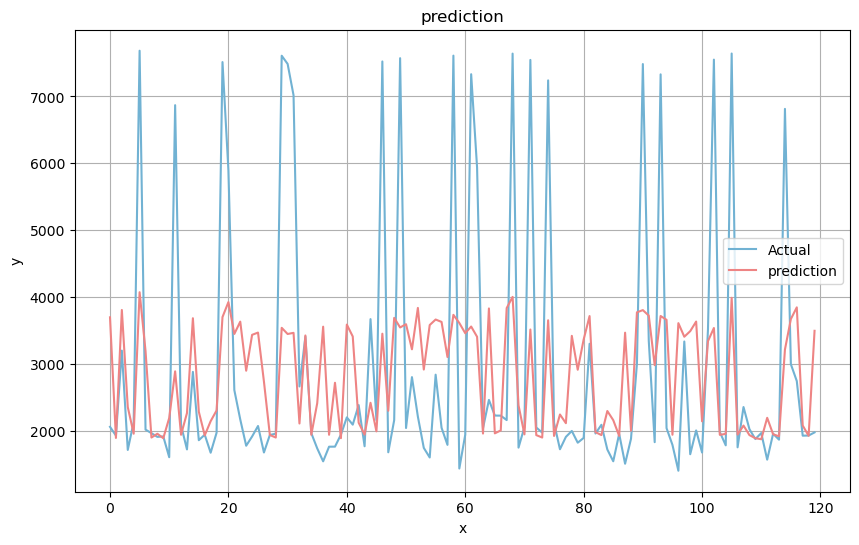

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

select_sdf = predictions[5].select("전력소비량(kWh)", "prediction")

# Pandas DataFrame으로 변환
select_pdf = select_sdf.toPandas()

plt.figure(figsize=(10, 6))

plt.plot(select_pdf.index.values, select_pdf["전력소비량(kWh)"].values, label='Actual', color='#71B2D3')

plt.plot(select_pdf.index.values, select_pdf["prediction"].values, label='prediction', color='#EE8484')

# 각 행의 두 요소를 순서대로 출력
for index, row in select_pdf.iterrows():
    print(row["전력소비량(kWh)"], row["prediction"])

# 그래프 꾸미기
plt.xlabel('x')
plt.ylabel('y')
plt.title('prediction')
plt.legend()
plt.grid(True)

8848.8 8811.203543285012
8702.64 8785.583297640796
8799.84 8803.256435371184
8661.6 8654.423569503184
8747.28 8783.411359107693
8791.92 8801.161540311785
8649.36 8648.043016044312
8869.68 8834.615881538373
8742.96 8795.00948665535
8807.76 8833.69332668822
8797.68 8814.02997541988
8880.48 8832.87566417007
8946.0 8824.009732556115
8896.32 8809.856701868324
8799.12 8783.578577584412
8670.24 8773.49344684346
8769.6 8807.639141633854
8651.52 8648.043016044312
8824.32 8869.59508680851
8807.04 8820.466141197121
8819.28 8821.759235240355
8718.48 8712.657706933709
8848.08 8825.140824678709
8904.96 8801.591576695897
8799.84 8830.182564330476
8656.56 8654.328560806798
8727.84 8713.441467400718
8725.68 8661.486676068833
8841.6 8789.666020410801
8893.44 8848.989885968498
8766.72 8786.121532050724
8819.28 8818.153573442642
8642.16 8626.630121760845
8824.32 8791.441700797355
8807.04 8856.9943989491
8799.84 8832.716063615027
8899.2 8797.084070110866
8881.2 8815.490878808701
8694.0 8705.797962130498
88

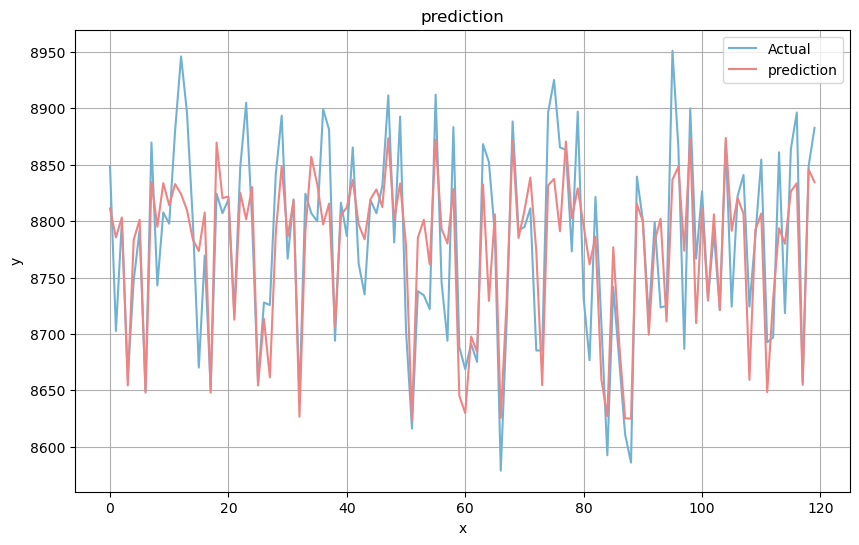

In [133]:
select_sdf_33 = predictions[33].select("전력소비량(kWh)", "prediction")

# Pandas DataFrame으로 변환
select_pdf_33 = select_sdf_33.toPandas()

plt.figure(figsize=(10, 6))

plt.plot(select_pdf_33.index.values, select_pdf_33["전력소비량(kWh)"].values, label='Actual', color='#71B2D3')

plt.plot(select_pdf_33.index.values, select_pdf_33["prediction"].values, label='prediction', color='#EE8484')

# 각 행의 두 요소를 순서대로 출력
for index, row in select_pdf_33.iterrows():
    print(row["전력소비량(kWh)"], row["prediction"])

# 그래프 꾸미기
plt.xlabel('x')
plt.ylabel('y')
plt.title('prediction')
plt.legend()
plt.grid(True)